<a href="https://colab.research.google.com/github/joshwa17sijuthomas/deeplearning-projects/blob/master/NLP_text_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install  -U transformers
!pip install  -U sentencepiece
!pip install  -U datasets
!pip install  -U accelerate
!pip install  -U bertviz
!pip install -U umap-learn
!pip install py7zr


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 62.6 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.2
    Uninstalling tokenizers-0.15.2:
      Successfully uninstalled tokenizers-0.15.2
  Attempting uninstall: transformers
    Found existing installation: transformers 4.38.2
    Uninstalling transformers-4.38.2:
      Successfully uninstalled transformers-4.38.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.4 MB/s eta 0:00:00
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.99
    Uninstalling sentencepiece-0.1.99:
      Successfully uninstalled sentencepiece-0.1.99
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5

In [3]:
!pip install --upgrade urllib3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 3.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.7
    Uninstalling urllib3-2.0.7:
      Successfully uninstalled urllib3-2.0.7


In [4]:
from datasets import load_dataset

from transformers import pipeline
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM
import torch



In [5]:
device = 'gpu'
model_name = 'facebook/bart-large-cnn'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

In [6]:
data_samsun = load_dataset("samsum")

Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

In [7]:
data_samsun

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})

In [8]:
len(data_samsun['train'][0])

3

In [9]:
data_samsun['train'][0]['dialogue']

"Amanda: I baked  cookies. Do you want some?\r\nJerry: Sure!\r\nAmanda: I'll bring you tomorrow :-)"

In [10]:
import pandas as pd

In [11]:
def get_feature(batch):
  encodings =tokenizer(batch['dialogue'], text_target=batch['summary'],max_length=1024,truncation=True, padding=True)
  encodings = {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'],'labels':encodings['labels']}
  return encodings

In [12]:
samsum_df = data_samsun.map(get_feature,batched =True)

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [13]:
samsum_df

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 818
    })
})

In [14]:
cols = ['input_ids','labels','attention_mask']
samsum_df.set_format(type='torch',columns=cols)

In [15]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [16]:
from transformers import TrainingArguments, Trainer
training_args = TrainingArguments(output_dir='bart_samsum',num_train_epochs=1,warmup_steps=500,
                                  per_device_train_batch_size=4,per_device_eval_batch_size=4,weight_decay=0.01,
                                  logging_steps=10,evaluation_strategy='steps',eval_steps = 500,save_steps=1e6,gradient_accumulation_steps=16)

trainer = Trainer(model=model,args=training_args,tokenizer = tokenizer,data_collator = data_collator,train_dataset=samsum_df['train'],eval_dataset=samsum_df['validation'])

In [17]:
trainer.train()

Step,Training Loss,Validation Loss


TrainOutput(global_step=230, training_loss=2.1743396987085757, metrics={'train_runtime': 1766.5159, 'train_samples_per_second': 8.34, 'train_steps_per_second': 0.13, 'total_flos': 2.925763903999181e+16, 'train_loss': 2.1743396987085757, 'epoch': 0.9991854466467553})

In [20]:
trainer.save_model('bart_finetuned_samsum')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


In [21]:
text = """ Alice: Hey Bob, are you free to discuss the project update right now?
  Bob: Hi Alice, yes I'm free now. What's the update?
  Alice: The client reviewed our latest draft and had some feedback.
  Bob: Oh, really? What did they say?
  Alice: They are happy with the progress but asked us to speed up a bit. They want the next draft by the end of next week.
  Bob: That’s tight, but I think we can manage that. I'll update the team right away.
  Alice: Thanks, Bob. I knew I could count on you.
  Bob: No problem, Alice. Let's touch base early next week to review everything.
  Alice: Sounds good! Have a great weekend!
  Bob: No problem, Alice. Let's touch base early next week to review everything.
  Alice: Sounds good! Have a great weekend!
  Bob: You too, Alice. Bye.
  Alice: Bye!"""


In [23]:
pipe = pipeline('summarization',model='bart_finetuned_samsum')
gen_kwargs = {"length_penalty": 0.7, "max_length": 128, "num_beams": 8}
summary = pipe(text,**gen_kwargs)
print(summary)

[{'summary_text': 'Bob is free to discuss the project update with Alice. The client reviewed their latest draft and had some feedback. They want the next draft by the end of next week. Bob will update the team right away. They will touch base early next week to review everything.'}]


In [31]:
from google.colab import files

# Download the file to your local computer
files.download('/content/bart_finetuned_samsum/model.safetensors')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [27]:
import zipfile
import os
def zip_folder(folder_path, output_path):
    """Zip the contents of an entire folder (with contents)."""
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as ziph:
        # ziph is zipfile handle
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                ziph.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file),
                                           os.path.join(folder_path, '..')))

folder_path = '/content/bart_finetuned_samsum'  # The path to the folder you want to zip
zip_path = '/content/bar_finetuned.zip'  # The path of the output zip file
zip_folder(folder_path, zip_path)

In [ ]:
#import liibraries

from transformers import pipeline
from transformers import AutoTokenizer,AutoModelForSeq2SeqLM
import torch
import spacy
from spacy import displacy
import nltk
import numpy as np
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.metrics.pairwise import cosine_similarity
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

import nltk
nltk.download('wordnet')

!pip install  -U transformers
!pip install  -U sentencepiece
!pip install  -U datasets
# !pip install  -U accelerate
!pip install  -U bertviz


In [38]:
!pip install -U umap-learn
!pip install py7zr

!pip install --upgrade urllib3
from transformers import DataCollatorForSeq2Seq
from transformers import TrainingArguments, Trainer


In [39]:
!pip install rouge

In [41]:
import nltk

In [44]:
from gensim.models import Word2Vec
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from rouge import Rouge
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
nltk.download('punkt')
nltk.download('stopwords')
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#import dataset
from datasets import load_dataset

data_samsun = load_dataset("samsum")

data_samsun

In [32]:
def BaseT5(text):
  T5pipe = pipeline('summarization',model='t5-base')
  output = T5pipe(text)
  return output



def BaseBert(text):
    Bertpipe = pipeline('summarization',model='t5-base')
    output = Bertpipe(text)
    return output

# def TrainedBert(data_samsun):

#   device = 'gpu'
#   model_name = 'facebook/bart-large-cnn'
#   tokenizer = AutoTokenizer.from_pretrained(model_name)
#   model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

#   def get_feature(batch):
#     encodings =tokenizer(batch['dialogue'], text_target=batch['summary'],max_length=1024,truncation=True, padding=True)
#     encodings = {'input_ids': encodings['input_ids'], 'attention_mask': encodings['attention_mask'],'labels':encodings['labels']}
#     return encodings

#   samsum_df = data_samsun.map(get_feature,batched =True)

#   cols = ['input_ids','labels','attention_mask']
#   samsum_df.set_format(type='torch',columns=cols)

#   data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)



#   training_args = TrainingArguments(output_dir='bart_samsum',num_train_epochs=1,warmup_steps=500,
#                                     per_device_train_batch_size=4,per_device_eval_batch_size=4,weight_decay=0.01,
#                                     logging_steps=10,evaluation_strategy='steps',eval_steps = 500,save_steps=1e6,gradient_accumulation_steps=16)

#   trainer = Trainer(model=model,args=training_args,tokenizer = tokenizer,data_collator = data_collator,train_dataset=samsum_df['train'],eval_dataset=samsum_df['validation'])

#   trainer.train()

#   trainer.save_pretrained('bart_finetuned_samsum')


def BartFineTunedModel(text):
  mypipe = pipeline('summarization',model='bart_finetuned_samsum')
  gen_kwargs = {"length_penalty": 0.7, "max_length": 128, "num_beams": 8}
  summary = mypipe(text,**gen_kwargs)
  return summary



def Word2Vec_extracted_summation(text):
  sentences = sent_tokenize(text)
  stop_words = set(stopwords.words('english'))

  # Tokenize each sentence into words, removing stopwords
  tokenized_sentences = [[word for word in word_tokenize(sentence.lower()) if word.isalnum() and word not in stop_words] for sentence in sentences]



  model4 = Word2Vec(tokenized_sentences, vector_size=100, window=5, min_count=1,   workers=4)

  def sentence_vector(sentence, model):
    words = [word  for word in word_tokenize(sentence.lower()) if word in model.wv and word.isalnum()]
    if words:
        return np.mean(model.wv[words], axis=0)
    else:
        return np.zeros(model.vector_size)

  sentence_vectors = np.array([sentence_vector(sentence, model4) for sentence in sentences])

  # print(sentence_vectors)

  similarity_matrix = cosine_similarity(sentence_vectors)

  # print(similarity_matrix)

  # Example heuristic: Sum of cosine similarities
  sentence_scores = similarity_matrix.sum(axis=0)

  # print(sentence_scores)

  # Get indices of top 3 sentences as summary
  top_sentence_indices = np.argsort(sentence_scores)[-3:]
  top_sentence_indices.sort()

  summary_sentences = [sentences[idx] for idx in top_sentence_indices]
  summary = ' '.join(summary_sentences)
  return summary




def Evaluation(target_text,prediction_text):
  rouge = Rouge()
  Rscores = rouge.get_scores(prediction_text, target_text)

  reference_tokenized = [word_tokenize(ref) for ref in reference]
  hypothesis_tokenized = word_tokenize(hypothesis)

  # Calculate METEOR Score
  score = meteor_score(reference_tokenized, hypothesis_tokenized)
  print("METEOR Score:", score)
  Mscore = meteor_score(reference_tokenized, hypothesis_tokenized)


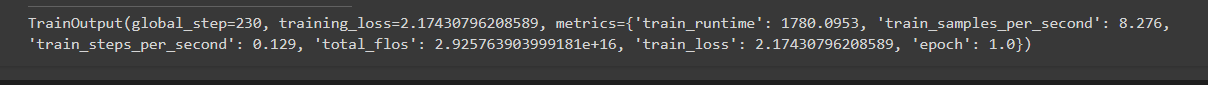

In [51]:
def run(input_sentence):

  target_summary = """ Alice and Bob discussed the client's feedback on their project, with the client
  requesting the next draft by the end of the next week. Bob agreed to inform the team and planned a follow-up meeting early next week."""

  text2 = """"In recent years, especially following the global health crisis of 2020, remote work has transformed from a niche option into a mainstay of the modern workforce. Companies around the world have been compelled to adopt remote working policies to ensure the safety and well-being of their employees. This shift has significant implications for how businesses operate and manage their teams.

  The benefits of remote work are manifold. Employees enjoy greater flexibility and a better work-life balance, which can lead to increased job satisfaction and productivity. Companies, on the other hand, can reduce overhead costs such as office space and utilities. Moreover, the talent pool for hiring is no longer geographically constrained, allowing for a more diverse workforce.

  However, remote work also presents several challenges. Collaboration and communication can be more difficult to manage without the face-to-face interaction that traditional office environments provide. This can lead to feelings of isolation and disconnection among team members. Additionally, remote work demands a high level of self-discipline and motivation, which not all employees may possess.

  Furthermore, the rapid shift to remote work has accelerated the digital transformation of businesses. Companies have had to invest significantly in technology and cybersecurity to support efficient and secure remote working environments. This technological shift is reshaping the corporate landscape, pushing companies to innovate and adapt at an unprecedented rate.

  In conclusion, while remote work offers numerous advantages to both employees and employers, it also requires careful management of the challenges it presents. As the world continues to navigate the repercussions of the global health crisis, the future of remote work remains a key topic of discussion among business leaders and policymakers."""

  text = """Alice: Hey Bob, are you free to discuss the project update right now?
  Bob: Hi Alice, yes I'm free now. What's the update?
  Alice: The client reviewed our latest draft and had some feedback.
  Bob: Oh, really? What did they say?
  Alice: They are happy with the progress but asked us to speed up a bit. They want the next draft by the end of next week.
  Bob: That’s tight, but I think we can manage that. I'll update the team right away.
  Alice: Thanks, Bob. I knew I could count on you.
  Bob: No problem, Alice. Let's touch base early next week to review everything.
  Alice: Sounds good! Have a great weekend!
  Bob: No problem, Alice. Let's touch base early next week to review everything.
  Alice: Sounds good! Have a great weekend!
  Bob: You too, Alice. Bye.
  Alice: Bye!"""

  target_summary = """ Alice and Bob discussed the client's feedback on their project, with the client
  requesting the next draft by the end of the next week. Bob agreed to inform the team and planned a follow-up meeting early next week."""

  output1 = BaseT5(text)
  output2 = BaseBert(text)
  output3 = Word2Vec_extracted_summation(text)
  output4 = BartFineTunedModel(text)

  print(output1)
  print(output2)
  print(output3)
  print(output4)

  final_output = []
  final_output.append(output1)
  final_output.append(output2)
  final_output.append(output3)
  final_output.append(output4)

  return final_output

In [52]:
return_values = run("start")

[{'summary_text': "the client reviewed our latest draft and had some feedback . they are happy with the progress but asked us to speed up a bit . I'll update the team right away ."}]
[{'summary_text': "the client reviewed our latest draft and had some feedback . they are happy with the progress but asked us to speed up a bit . I'll update the team right away ."}]
Bob: No problem, Alice. Bob: No problem, Alice. Bob: You too, Alice.
[{'summary_text': 'Bob is free to discuss the project update with Alice. The client reviewed their latest draft and had some feedback. They want the next draft by the end of next week. Bob will update the team right away. They will touch base early next week to review everything.'}]


In [55]:
return_values[0][0]['summary_text']

"the client reviewed our latest draft and had some feedback . they are happy with the progress but asked us to speed up a bit . I'll update the team right away ."

In [56]:
return_values[1][0]['summary_text']

"the client reviewed our latest draft and had some feedback . they are happy with the progress but asked us to speed up a bit . I'll update the team right away ."

In [58]:
return_values[3][0]['summary_text']

'Bob is free to discuss the project update with Alice. The client reviewed their latest draft and had some feedback. They want the next draft by the end of next week. Bob will update the team right away. They will touch base early next week to review everything.'

In [59]:
target_summary = """ Alice and Bob discussed the client's feedback on their project, with the client
  requesting the next draft by the end of the next week. Bob agreed to inform the team and planned a follow-up meeting early next week."""

In [60]:
[target_summary]

[" Alice and Bob discussed the client's feedback on their project, with the client \n  requesting the next draft by the end of the next week. Bob agreed to inform the team and planned a follow-up meeting early next week."]